In [1]:
# Laboratorio 3
## Microestructuras y Sistemas de Trading
###  Karen Medel y Pablo Mendoza


In [2]:
# -- Libraries Importation -- #
import ta as ta
import numpy as np
import pandas as pd
%matplotlib inline
from oandapyV20 import API
import matplotlib.pyplot as plt
from datetime import date
from dateutil.relativedelta import relativedelta
import oandapyV20.endpoints.instruments as instruments
# -- DataFrame Parameters -- #
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)


In [3]:
# -- OANDA Parameters -- #
A1_OA_Da = 16                     # Day Align
A1_OA_Ta = "America/Mexico_City"  # Time Align
A1_OA_Ai = "101-004-2221697-001"  # Id de cuenta
A1_OA_At = "practice"             # Tipo de cuenta
A1_OA_In = "USD_MXN"              # Instrumento
A1_OA_Gn = "M5"                   # Granularidad de velas (Minutes 5)
A1_OA_Ak = '4' + 'df969137c0bf800c5a04604c49450db-0e783d4124aa50b5736ebfe1a350eac' + '1'

# -- Data Range Function -- # 


def date_range(start_date_, end_date_, increment, period):
    """
    This function creates a list of the data range that will be imported
    :param start_date_: Start Date
    :param end_date_: End Date
    :param increment: number of increments
    :param period: type of increment (days, hours, minutes, etc)
    :return: list of the data range
    """
    result = []
    nxt = start_date_
    delta = relativedelta(**{period: increment})
    while nxt <= end_date_:
        result.append(nxt)
        nxt += delta
    return result


In [ ]:
# -- Download Initial Data -- #
start_date = date(2019, 2, 25)  # Date for all transactions date(2017, 2, 16)
end_date = date(2019, 3, 5)  # Date for all transactions date(2019, 3, 5)
date_a = date_range(start_date, end_date, 1, 'days')
list_a = []
for n_date in range(len(date_a)-1):
    F1 = date_a[n_date].strftime('%Y-%m-%dT%H:%M:%S')
    F2 = date_a[n_date+1].strftime('%Y-%m-%dT%H:%M:%S')
    
    # -- OANDA API Initialisation -- #
    api = API(access_token=A1_OA_Ak)
    # -- Historical DAta Download -- #
    params = {"granularity": A1_OA_Gn, "price": "M", "dailyAlignment": A1_OA_Da,
              "alignmentTimezone": A1_OA_Ta, "from": F1, "to": F2}
    A1_Req1 = instruments.InstrumentsCandles(instrument=A1_OA_In, params=params)
    A1_Hist = api.request(A1_Req1)
    for i in range(len(A1_Hist['candles'])-1):
            list_a.append({'TimeStamp': A1_Hist['candles'][i]['time'],
                           'Open': A1_Hist['candles'][i]['mid']['o'],
                           'High': A1_Hist['candles'][i]['mid']['h'],
                           'Low': A1_Hist['candles'][i]['mid']['l'],
                           'Close': A1_Hist['candles'][i]['mid']['c']})

pd_hist = pd.DataFrame(list_a)
pd_hist = pd_hist[['TimeStamp', 'Open', 'High', 'Low', 'Close']]
pd_hist['TimeStamp'] = pd.to_datetime(pd_hist['TimeStamp'])
pd_hist['Open'] = pd.to_numeric(pd_hist['Open'])
pd_hist['High'] = pd.to_numeric(pd_hist['High'])
pd_hist['Low'] = pd.to_numeric(pd_hist['Low'])
pd_hist['Close'] = pd.to_numeric(pd_hist['Close'])
print(pd_hist.head())
print(pd_hist.tail())
# -- Data Structure -- #
df1_Prices = pd_hist
# df1_Prices.to_csv('Data_Set_Technical_Analysis.csv')



In [4]:
# -- Indicators Functions from Technical Analysis (T.A.) -- #
# These functions will add a column to the Historical DataFrame with the value of the indicator.
# T.A. library has implemented 32 indicators:
## Volume
    # Accumulation/Distribution Index (ADI)
    # On-Balance Volume (OBV)
    # On-Balance Volume mean (OBV mean)
    # Chaikin Money Flow (CMF)
    # Force Index (FI)
    # Ease of Movement (EoM, EMV)
    # Volume-price Trend (VPT)
    # Negative Volume Index (NVI)
## Volatility
    # Average True Range (ATR)
    # Bollinger Bands (BB)
    # Keltner Channel (KC)
    # Donchian Channel (DC)
## Trend
    # Moving Average Convergence Divergence (MACD)
    # Average Directional Movement Index (ADX)
    # Vortex Indicator (VI)
    # Trix (TRIX)
    # Mass Index (MI)
    # Commodity Channel Index (CCI)
    # Detrended Price Oscillator (DPO)
    # KST Oscillator (KST)
    # Ichimoku Kinkō Hyō (Ichimoku)
## Momentum
    # Money Flow Index (MFI)
    # Relative Strength Index (RSI)
    # True strength index (TSI)
    # Ultimate Oscillator (UO)
    # Stochastic Oscillator (SR)
    # Williams %R (WR)
    # Awesome Oscillator (AO)
## Others
    # Daily Return (DR)
    # Daily Log Return (DLR)
    # Cumulative Return (CR)
    

In [5]:
df1_Prices = pd.read_csv('Data_Set_Technical_Analysis.csv')  # size (151536, 6)
df1_Prices = df1_Prices.iloc[0:500, :]
# -- Technical Analysis Indicators Calculations -- #
df1_Prices['BBH_Close'] = ta.bollinger_hband(df1_Prices['Close'], 150)
df1_Prices['BBL_Close'] = ta.bollinger_lband(df1_Prices['Close'], 150)
df1_Prices['RSI_Close'] = ta.rsi(df1_Prices['Close'], 51)
df1_Prices['STO_Close'] = ta.momentum.stoch(df1_Prices['High'], df1_Prices['Low'], df1_Prices['Close'], 200, False)


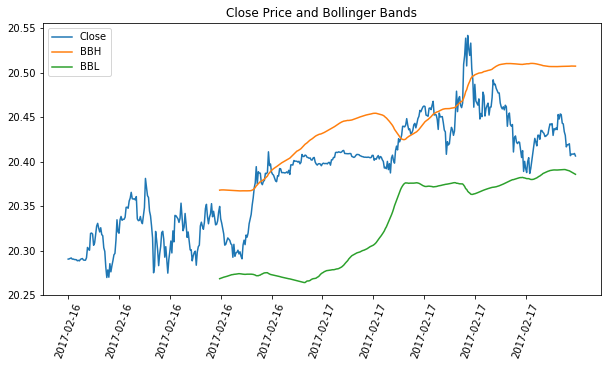

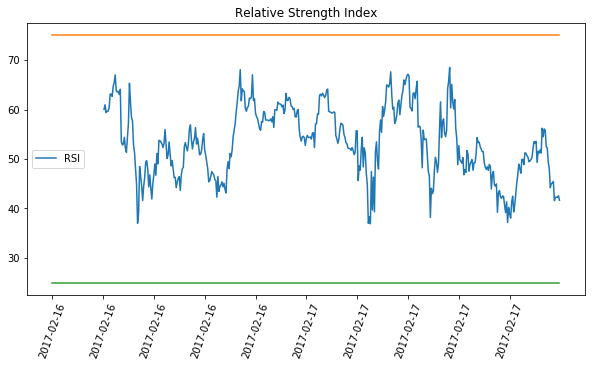

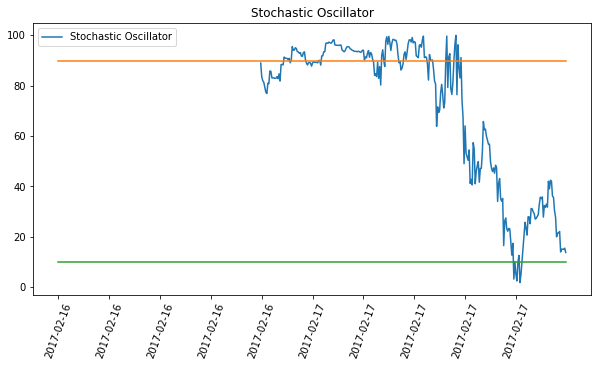

In [6]:
# -- Indicators Functions to Open and Close positions -- #
# These functions will Open and Close positions depending of the values of each T.A. indicators.
# For opening operations, Take Profit (TP) level will be 2000 pips from spot.
# For closing operations, Stop Loss (SL) level will be 1000 pips from spot.
# TP and SL levels will be above or below spot depending if the position is Long or Short.
# -- Activation and Deactivation Parameters
# Bollinger Bands activate when the spot cross the Bollinger Bands from bellow(High Band) and from above(Low Band)
RSI_Param_UP = 75
RSI_Param_DW = 25
STO_Param_UP = 90
STO_Param_DW = 10
TP = .0200
SL = .0100
Units = 10

# -- Axes Legend -- #
n_tick = 10
list_a_ = [(np.floor(len(df1_Prices)/n_tick)), (np.floor(len(df1_Prices)/n_tick))]
list_b_ = [np.arange(n_tick)]
c = [a*b for a, b in zip(list_a_, list_b_)]
d = tuple([(str(df1_Prices['TimeStamp'][i])[0:10]) for i in c[0]])
# -- Bollinger Bands Graph -- #
plt.figure(1, figsize=(10, 5))
plt.title('Close Price and Bollinger Bands')
plt.plot(df1_Prices['Close'], label='Close')
plt.plot(df1_Prices['BBH_Close'], label='BBH')
plt.plot(df1_Prices['BBL_Close'], label='BBL')
plt.xticks(rotation=70)
plt.xticks(np.arange(0, len(df1_Prices), len(df1_Prices)/n_tick), d)
plt.legend()
plt.show()

# -- RSI Graph -- #
plt.figure(2, figsize=(10, 5))
plt.title('Relative Strength Index')
plt.plot(df1_Prices['RSI_Close'], label='RSI')
plt.plot(np.ones(len(df1_Prices))*RSI_Param_UP)
plt.plot(np.ones(len(df1_Prices))*RSI_Param_DW)
plt.xticks(rotation=70)
plt.xticks(np.arange(0, len(df1_Prices), len(df1_Prices)/n_tick), d)
plt.legend()
plt.show()

# -- Stochastic Oscilator Graph -- #
plt.figure(3, figsize=(10, 5))
plt.title('Stochastic Oscillator')
plt.plot(df1_Prices['STO_Close'], label='Stochastic Oscillator')
plt.plot(np.ones(len(df1_Prices))*STO_Param_UP)
plt.plot(np.ones(len(df1_Prices))*STO_Param_DW)
plt.xticks(rotation=70)
plt.xticks(np.arange(0, len(df1_Prices), len(df1_Prices)/n_tick), d)
plt.legend()
plt.show()


In [7]:
# -- Paso 2 -- en Data Frame (df2_operaciones)
# -- -- Fecha, Folio (1 a n), Operacion (1 = compra, -1 = venta), Unidades (0 a n),
# -- -- Margen (0 a n), Comentario ("razon con base al indicador")
# -- -- Precio_apertura, Precio_cierre

In [8]:
df2_Operations = pd.DataFrame(columns=['Folio', 'Ini_Date', 'End_Date', 'Operation_Type', 'Comment',
                                       'Units', 'Spot', 'TP', 'SL', 'Status', 'Margin'])
# -- Operation Open and Close Algorithm -- #
for n_ in range(len(df1_Prices)):
    # -- Add Operation -- #
    if df1_Prices['RSI_Close'][n_] >= RSI_Param_UP:
        df2_Operations.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Sell', 'RSI', 
                                  Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] - TP, 
                                  df1_Prices['Close'][n_] + SL, 'Open', '-']
        df2_Operations.index = df2_Operations.index + 1
    elif df1_Prices['RSI_Close'][n_] <= RSI_Param_DW:
        df2_Operations.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Buy', 'RSI', 
                                  Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] + TP, 
                                  df1_Prices['Close'][n_] - SL, 'Open', '-']
        df2_Operations.index = df2_Operations.index + 1   
    elif df1_Prices['STO_Close'][n_] >= STO_Param_UP:
        df2_Operations.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Sell', 'STO', 
                                  Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] - TP, 
                                  df1_Prices['Close'][n_] + SL, 'Open', '-']
        df2_Operations.index = df2_Operations.index + 1
    elif df1_Prices['STO_Close'][n_] <= STO_Param_DW:
        df2_Operations.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Buy', 'STO', 
                                  Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] + TP, 
                                  df1_Prices['Close'][n_] - SL, 'Open', '-']
        df2_Operations.index = df2_Operations.index + 1  
    elif df1_Prices['BBL_Close'][n_] >= df1_Prices['Close'][n_]:
        df2_Operations.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Buy', 'BBL', 
                                  Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] + TP, 
                                  df1_Prices['Close'][n_] - SL, 'Open', '-']
        df2_Operations.index = df2_Operations.index + 1     
    elif df1_Prices['BBH_Close'][n_] <= df1_Prices['Close'][n_]:
        df2_Operations.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Sell', 'BBH', 
                                  Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] - TP, 
                                  df1_Prices['Close'][n_] + SL, 'Open', '-']
        df2_Operations.index = df2_Operations.index + 1
    else:
        pass
    # -- Check and Close Operation -- #
    df_Temp = df2_Operations[df2_Operations['Status'] == 'Open']
    for n_2 in df_Temp.index:
        if df_Temp['Operation_Type'][n_2] == 'Buy' and df_Temp['TP'][n_2] <= df1_Prices['Close'][n_]:
            df2_Operations['Status'][n_2] = 'Closed'
            df2_Operations['End_Date'][n_2] = df1_Prices['TimeStamp'][n_]
            df2_Operations['Margin'][n_2] = df1_Prices['Close'][n_] - df2_Operations['Spot'][n_2]
            df_Temp = df2_Operations[df2_Operations['Status'] == 'Open']
        elif df_Temp['Operation_Type'][n_2] == 'Buy' and df_Temp['SL'][n_2] >= df1_Prices['Close'][n_]:
            df2_Operations['Status'][n_2] = 'Closed'
            df2_Operations['End_Date'][n_2] = df1_Prices['TimeStamp'][n_]
            df2_Operations['Margin'][n_2] = df1_Prices['Close'][n_] - df2_Operations['Spot'][n_2]
            df_Temp = df2_Operations[df2_Operations['Status'] == 'Open']
        elif df_Temp['Operation_Type'][n_2] == 'Sell' and df_Temp['TP'][n_2] >= df1_Prices['Close'][n_]: 
            df2_Operations['Status'][n_2] = 'Closed'
            df2_Operations['End_Date'][n_2] = df1_Prices['TimeStamp'][n_]
            df2_Operations['Margin'][n_2] = df2_Operations['Spot'][n_2] - df1_Prices['Close'][n_]
            df_Temp = df2_Operations[df2_Operations['Status'] == 'Open']
        elif df_Temp['Operation_Type'][n_2] == 'Sell' and df_Temp['SL'][n_2] <= df1_Prices['Close'][n_]:
            df2_Operations['Status'][n_2] = 'Closed'
            df2_Operations['End_Date'][n_2] = df1_Prices['TimeStamp'][n_]
            df2_Operations['Margin'][n_2] = df2_Operations['Spot'][n_2] - df1_Prices['Close'][n_]
            df_Temp = df2_Operations[df2_Operations['Status'] == 'Open']
        else:
            pass
    if n_%100 == 0:
        print(n_)


0
100


/Users/pablomendoza/Pycharm/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/pablomendoza/Pycharm/lib/python3.6/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/pablomendoza/Pycharm/lib/python3.6/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/Users/pablomendoza/Pycharm/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/pablomendoza/Pycharm/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/pablomendoza/Pycharm/lib/python3.6/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


200


300


400


/Users/pablomendoza/Pycharm/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/pablomendoza/Pycharm/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/pablomendoza/Pycharm/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/pablomendoza/Pycharm/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A val

In [10]:
print(sum(df2_Operations[df2_Operations['Status'] == 'Closed']['Margin']))

-0.17463999999995394


In [10]:
print(df2_Operations[df2_Operations['Status'] == 'Closed'])

     Folio          Ini_Date                   End_Date Operation_Type Comment Units      Spot        TP        SL  Status   Margin
150  Folio  2017-02-16 20:15  2017-02-16 20:25:00+00:00           Sell     BBH    10  20.37046  20.35046  20.38046  Closed  -0.0238
149  Folio  2017-02-16 20:20  2017-02-16 20:25:00+00:00           Sell     BBH    10  20.37594  20.35594  20.38594  Closed -0.01832
148  Folio  2017-02-16 20:25  2017-02-16 20:55:00+00:00           Sell     BBH    10  20.39426  20.37426  20.40426  Closed  0.02025
147  Folio  2017-02-16 20:30  2017-02-16 20:35:00+00:00           Sell     BBH    10  20.37495  20.35495  20.38495  Closed -0.01359
146  Folio  2017-02-16 20:35  2017-02-16 21:25:00+00:00           Sell     BBH    10  20.38854  20.36854  20.39854  Closed  -0.0224
145  Folio  2017-02-16 20:40  2017-02-16 21:25:00+00:00           Sell     BBH    10  20.38708  20.36708  20.39708  Closed -0.02386
144  Folio  2017-02-16 20:45  2017-02-16 21:25:00+00:00           Sell     B

In [11]:
print(df2_Operations[df2_Operations['Status'] == 'Open'])

Empty DataFrame
Columns: [Folio, Ini_Date, End_Date, Operation_Type, Comment, Units, Spot, TP, SL, Status, Margin]
Index: []


In [ ]:
# -- Operation DataFrame -- #



# -- Paso 3 -- en Data Frame Cuenta (df3_cuenta)
# -- -- Fecha, Capital (Efectivo $), Flotante ($),
# -- -- Balance (Capital+Flotante), Rend_Balance_acm, Comentario ("Se abrio operacion: compra/venta",
# -- -- "Se cerro operacion: Con perdia de: / Con ganancia de: ", 

# -- Paso 4 -- Generar un vector de fechas, de F1 hasta F2

par0_cap = 100000   # Capital a utilizar $100,000 Usd
par1_mar = 1000000  # Unidades por operacion maximo 1'000,000


# -- Criterios para trading
# -- para cerrar una operacion: 1) TP o SL, 2) Regla con indicador

indice = [1, 2, 3, 4, 5]
columnas = ['A','B', 'C', 'D']
df = pd.DataFrame(index=indice, columns=columnas)
df = df.fillna(0) # -- llenar todas las celdas con 0s
